#  INF8225 Projet QA : HyDE vs RAG-Fusion

## Import des librairies

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Optional
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM, pipeline, BitsAndBytesConfig
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from nltk.translate.bleu_score import sentence_bleu
import nltk
import faiss
import torch.nn.functional as F
from torch.utils.data import Dataset

import os
import torch
from torch.utils.data import DataLoader
from transformers import AdamW
from tqdm import tqdm
import random

## Déclarations des constantes

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16

## Chargement des données

In [3]:
root_path = './'
data_path = root_path + 'data/'
questions_test = pd.read_csv(data_path + 'questions_test.csv')
questions_train = pd.read_csv(data_path+'questions_train.csv')
questions_val = pd.read_csv(data_path+'questions_val.csv')
texts = pd.read_csv(data_path + 'texts.csv')

# Colonnes utiles
passages = texts['text'].tolist()
questions_t = questions_test['question'].tolist()
questions_tr = questions_train['question'].tolist()
questions_v = questions_val['question'].tolist()

## Encoding

### Chargement de l'encodeur

In [4]:
from transformers import AutoTokenizer, AutoModel
model_name = 'BAAI/bge-base-en-v1.5'
emb_tokenizer = AutoTokenizer.from_pretrained(model_name)
emb_model = AutoModel.from_pretrained(model_name)
emb_model.to(DEVICE)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [5]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "key", "value"],
    lora_dropout=0.05,
    bias="none",
)

emb_model = get_peft_model(emb_model, lora_config)

In [ ]:
emb_model.load_state_dict(torch.load("models_encoder/fine_tuned_model_weights_epoch_8.pth"))

### Stockage dans FAISS

In [7]:
def encode_sequences(sequences: list, tokenizer, model, device=DEVICE, batch_size=BATCH_SIZE, training=False) -> torch.Tensor:
    model.train() if training else model.eval()
    context = torch.enable_grad() if training else torch.no_grad()

    embeddings = []
    with context:
        for i in range(0, len(sequences), batch_size):
            batch = sequences[i:i + batch_size]

            # Tokenisation des textes avant entrée du modèle
            inputs = tokenizer(
                batch, padding=True, truncation=True, return_tensors="pt"
            ).to(device)

            # Passage dans le modèle encodeur
            output = model(**inputs).last_hidden_state

            # Pooling : moyenne des vecteurs de tous les tokens pour chaque séquence
            pooled = output.mean(dim=1)  # [batch_size, hidden_size]

            embeddings.append(pooled)

    # Concatène tous les embeddings pour obtenir un seul tensor de sortie
    return torch.cat(embeddings, dim=0)

In [8]:
passage_embed = encode_sequences(passages, emb_tokenizer, emb_model)
passage_embeddings = passage_embed.cpu().numpy()
faiss.normalize_L2(passage_embeddings) #  Normalisation des vecteurs pour l'approche similarité cosinus
d = passage_embeddings.shape[1]
index = faiss.IndexFlatIP(d)  # Index Faiss
index.add(passage_embeddings)

In [9]:
def retrieve_top_k_passages_faiss(questions: list, vector_index: faiss.IndexFlatL2, embedding_model_tokenizer, embedding_model, k: int):
    question_embeddings = encode_sequences(questions, embedding_model_tokenizer, embedding_model)
    question_embeddings = question_embeddings.cpu().numpy()
    faiss.normalize_L2(question_embeddings)
    _, top_k_indices = vector_index.search(question_embeddings, k)
    
    return top_k_indices

## RAG Fusion

### Rephrasing

In [10]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_name = "google/flan-t5-base"
rag_fus_tokenizer = AutoTokenizer.from_pretrained(model_name)
rag_fus_model = AutoModelForSeq2SeqLM.from_pretrained(model_name, device_map="auto", torch_dtype=torch.float16)
rag_fus_model.to(DEVICE)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):

In [10]:
def generate_reformulations_flant5(question, model, tokenizer, n=5):
    prompt_template = (
        f"Question: {question.strip()}\n\n"
        "Rephrase this question in a different way"
    )
    return [
        tokenizer.decode(
            model.generate(
                **tokenizer(prompt_template, return_tensors="pt").to(model.device),
                max_new_tokens=64,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=0.9,
            )[0],
            skip_special_tokens=True,
        )
        for _ in range(n)
    ]

In [ ]:
from transformers import T5ForConditionalGeneration,T5Tokenizer

rag_fus_model2 = T5ForConditionalGeneration.from_pretrained('ramsrigouthamg/t5_paraphraser')
rag_fus_tokenizer2 = T5Tokenizer.from_pretrained('ramsrigouthamg/t5_paraphraser')
rag_fus_model2 = rag_fus_model2.to(DEVICE)

In [12]:
def generate_reformulations_t5paraphraser(question, model, tokenizer, n=5):
    text = f"paraphrase: {question} </s>"
    encoding = tokenizer.encode_plus(
        text, return_tensors="pt", padding=True, truncation=True, max_length=256
    ).to(model.device)

    print(text)

    outputs = model.generate(
        input_ids=encoding["input_ids"],
        attention_mask=encoding["attention_mask"],
        do_sample=True,
        max_length=256,
        top_k=120,
        top_p=0.98,
        early_stopping=True,
        num_return_sequences=n * 2  # générer plus et filtrer les doublons
    )

    results = []
    for output in outputs:
        decoded = tokenizer.decode(output, skip_special_tokens=True)
        if decoded.lower() != question.lower() and decoded not in results:
            results.append(decoded)
        if len(results) >= n:
            break
    return results

In [13]:
def generate_reformulations(question, model, tokenizer, method="flant5", n=5):
    if method == "flant5":
        return generate_reformulations_flant5(question, model, tokenizer, n)
    elif method == "paraphraser":
        return generate_reformulations_t5paraphraser(question, model, tokenizer, n)

## RAG Fusion Pipeline

In [15]:
from collections import defaultdict

def retrieve_rag_fusion_rrf(question, model, tokenizer, faiss_index, emb_model, emb_tokenizer, 
                            k=5, reform_method="flant5", n_reform=5, rrf_k=60, prefilter_top_n=20):
    reformulations = generate_reformulations(question, model, tokenizer, reform_method, n_reform)

    # RRF fusion
    rrf_scores = defaultdict(float)
    for q in reformulations:
        top_ids = retrieve_top_k_passages_faiss([q], faiss_index, emb_tokenizer, emb_model, k)[0]
        for rank, passage_id in enumerate(top_ids):
            score = 1 / (rank + 1 + rrf_k)
            rrf_scores[passage_id] += score

    # Trier et retourner les top-N documents
    sorted_ids = [doc_id for doc_id, _ in sorted(rrf_scores.items(), key=lambda x: x[1], reverse=True)]
    return sorted_ids[:prefilter_top_n]


def run_rag_fusion_pipeline_rrf(questions, reform_model, reform_tokenizer, reform_method, 
                                faiss_index, emb_model, emb_tokenizer, 
                                k=5, n_reform=5, rrf_k=60, prefilter_top_n=20):
    results = {}
    for q_index, question in enumerate(questions):
        print(f"[{q_index+1}/{len(questions)}] Processing question: {question}")
        retrieved_ids = retrieve_rag_fusion_rrf(
            question,
            reform_model,
            reform_tokenizer,
            faiss_index,
            emb_model,
            emb_tokenizer,
            k=k,
            reform_method=reform_method,
            n_reform=n_reform,
            rrf_k=rrf_k,
            prefilter_top_n=prefilter_top_n
        )
        results[question] = retrieved_ids
    return results

In [16]:
reform_method = "paraphraser"

results = run_rag_fusion_pipeline_rrf(
    questions=questions_v,            
    reform_model=rag_fus_model2,
    reform_tokenizer=rag_fus_tokenizer2,
    reform_method=reform_method,
    faiss_index=index,
    emb_model=emb_model,
    emb_tokenizer=emb_tokenizer,
    k=5,
    n_reform=5,
    rrf_k=60,
    prefilter_top_n=30   # combien de passages on rerank après RRF
)

print(results)

[1/500] Processing question: What is the effect of the M201V variant of CYSLTR2 on responsiveness to LTD4?
paraphrase: What is the effect of the M201V variant of CYSLTR2 on responsiveness to LTD4? </s>


c:\Users\mathi\anaconda3\envs\rag_env\Lib\site-packages\transformers\models\t5\tokenization_t5.py:289: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
c:\Users\mathi\anaconda3\envs\rag_env\Lib\site-packages\transformers\generation\configuration_utils.py:677: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


[2/500] Processing question: What is the key difference in the structure of carbapenems compared to penicillins?
paraphrase: What is the key difference in the structure of carbapenems compared to penicillins? </s>
[3/500] Processing question: What type of facets are there in the 8-demicubic honeycomb?
paraphrase: What type of facets are there in the 8-demicubic honeycomb? </s>
[4/500] Processing question: What is the legal status of 5F-AMB in the United States?
paraphrase: What is the legal status of 5F-AMB in the United States? </s>
[5/500] Processing question: What is converted into estrone sulfamate by 17β-hydroxysteroid dehydrogenase?
paraphrase: What is converted into estrone sulfamate by 17β-hydroxysteroid dehydrogenase? </s>
[6/500] Processing question: What receptors does 3-HO-PCP have high affinity for?
paraphrase: What receptors does 3-HO-PCP have high affinity for? </s>
[7/500] Processing question: What is the location of the PAI-1 gene?
paraphrase: What is the location of t

### Evaluation

In [19]:
def compute_recall_at_k(ground_truth, predictions):
    total_recall = 0
    for true_texts, predicted_texts in zip(ground_truth, predictions):

        true_set = set(true_texts)  
        predicted_set = set(predicted_texts)

        relevant_and_retrieved = true_set.intersection(predicted_set)
        
        recall = len(relevant_and_retrieved) / len(true_set)
        total_recall += recall
   
    average_recall = total_recall / len(ground_truth) 
    return average_recall


def compute_precision_at_k(ground_truth, predictions):
    total_precision = 0
    for true_texts, predicted_texts in zip(ground_truth, predictions):
        true_set = set(true_texts)
        predicted_set = set(predicted_texts)
        relevant_and_retrieved = true_set.intersection(predicted_set)
        
        precision = len(relevant_and_retrieved) / len(predicted_set) 
        total_precision += precision
    
    average_precision = total_precision / len(ground_truth) 
    return average_precision

def compute_f1_at_k(ground_truth, predictions):
    total_f1 = 0
    for true_texts, predicted_texts in zip(ground_truth, predictions):
        true_set = set(true_texts)
        predicted_set = set(predicted_texts)
        relevant_and_retrieved = true_set.intersection(predicted_set)

        precision = len(relevant_and_retrieved) / len(predicted_set) if predicted_set else 0
        recall = len(relevant_and_retrieved) / len(true_set) if true_set else 0

        if precision + recall == 0:
            f1 = 0
        else:
            f1 = 2 * (precision * recall) / (precision + recall)

        total_f1 += f1

    average_f1 = total_f1 / len(ground_truth)
    return average_f1

top_ground_truth = questions_val['text_ids'].apply(lambda x: [int(num) for num in x.strip('[]').split()]).to_list()

k_values = range(1, 6)
recall = []
precision = []
f1_scores = []

for k in k_values:
    top_passages_k = [
        results[q][:k] if q in results else []
        for q in questions_v
    ]
    
    rec_at_k = compute_recall_at_k(top_ground_truth, top_passages_k)
    prec_at_k = compute_precision_at_k(top_ground_truth, top_passages_k)
    f1_at_k = compute_f1_at_k(top_ground_truth, top_passages_k)

    recall.append(rec_at_k)
    precision.append(prec_at_k)
    f1_scores.append(f1_at_k)

    print(f'Precision@{k} = {round(prec_at_k, 3)}')
    print(f'Recall@{k} = {round(rec_at_k, 3)}\n')
    print(f'F1@{k} = {round(f1_at_k, 3)}\n')

Precision@1 = 0.862
Recall@1 = 0.322

F1@1 = 0.462

Precision@2 = 0.669
Recall@2 = 0.485

F1@2 = 0.553

Precision@3 = 0.577
Recall@3 = 0.62

F1@3 = 0.587

Precision@4 = 0.524
Recall@4 = 0.743

F1@4 = 0.605

Precision@5 = 0.475
Recall@5 = 0.838

F1@5 = 0.597



In [20]:
metrics_df = pd.DataFrame({
    'k': list(range(1, 6)),
    'Precision@k': precision,
    'Recall@k': recall,
    'F1@k': f1_scores
})

print(metrics_df)

   k  Precision@k  Recall@k      F1@k
0  1     0.862000  0.322000  0.462400
1  2     0.669000  0.485333  0.553000
2  3     0.576667  0.620167  0.587410
3  4     0.524500  0.743167  0.604833
4  5     0.475200  0.838333  0.597024


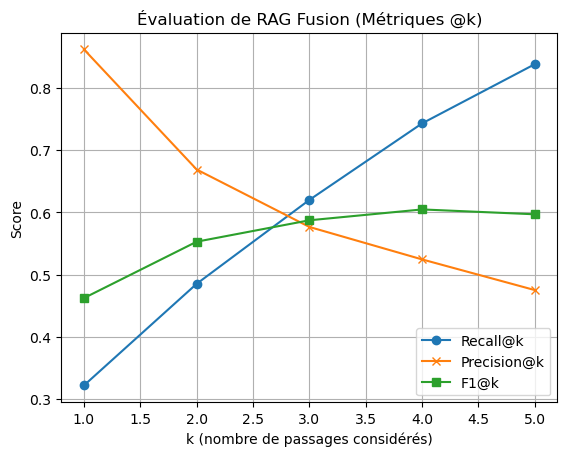

In [21]:
plt.plot(metrics_df['k'], metrics_df['Recall@k'], marker='o', label='Recall@k')
plt.plot(metrics_df['k'], metrics_df['Precision@k'], marker='x', label='Precision@k')
plt.plot(metrics_df['k'], metrics_df['F1@k'], marker='s', label='F1@k')
plt.xlabel('k (nombre de passages considérés)')
plt.ylabel('Score')
plt.title('Évaluation de RAG Fusion (Métriques @k)')
plt.legend()
plt.grid(True)
plt.savefig('evaluation_rag_fusion.png', dpi=300, bbox_inches='tight') 
plt.show()